In [1]:
import os, math
import zipfile
import numpy as np
import tensorflow as tf
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display

from matplotlib import pyplot as plt

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Data Set Batik**

In [2]:
local_zip = 'Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

base_dir = 'Dataset'
train_dir = os.path.join(base_dir, 'TRAIN')
validation_dir = os.path.join(base_dir, 'TEST')

BATCH_SIZE = 20
EPOCHS = 100

In [3]:
#TEST
# Directory with our training Batik Kawung pictures
train_kawung_dir = os.path.join(train_dir, 'Batik Kawung')

# Directory with our training Batik Megamendung pictures
train_megamendung_dir = os.path.join(train_dir, 'Batik Megamendung')

# Directory with our training Batik Parang pictures
train_parang_dir = os.path.join(train_dir, 'Batik Parang')

# Directory with our training Batik Tambal pictures
train_tambal_dir = os.path.join(train_dir, 'Batik Tambal')

#TEST
# Directory with our validation Batik Dayak pictures
validation_kawung_dir = os.path.join(validation_dir, 'Batik Kawung')

# Directory with our validation Batik Poleng pictures
validation_megamendung_dir = os.path.join(validation_dir, 'Batik Megamendung')

# Directory with our validation Batik Parang pictures
validation_parang_dir = os.path.join(validation_dir, 'Batik Parang')

# Directory with our validation Batik Tambal pictures
validation_tambal_dir = os.path.join(validation_dir, 'Batik Tambal')

In [4]:
# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      #shear_range=0.2,
      zoom_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 150x150
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(200, 200),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 280 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [5]:
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(24, (3,3), input_shape=(200, 200, 3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('tanh'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(32, (6,6)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('tanh'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32, (6,6)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('tanh'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1)),

    tf.keras.layers.Conv2D(12, (3,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('tanh'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 24)      672       
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 24)     72        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 198, 198, 24)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 24)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        27680     
                                                                 
 batch_normalization_1 (Batc  (None, 94, 94, 32)       9

In [7]:
labels = train_generator.class_indices.keys()
print(labels)

dict_keys(['Batik Kawung', 'Batik Megamendung', 'Batik Parang', 'Batik Tambal'])


In [8]:
def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

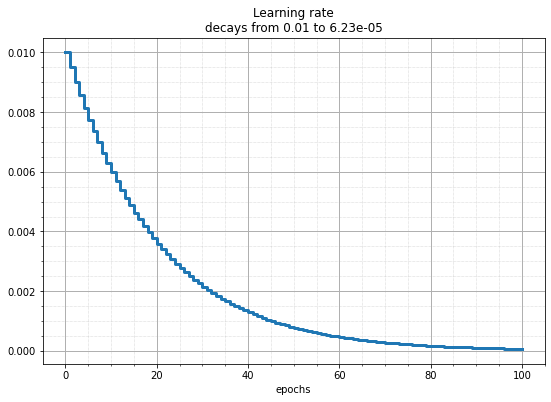

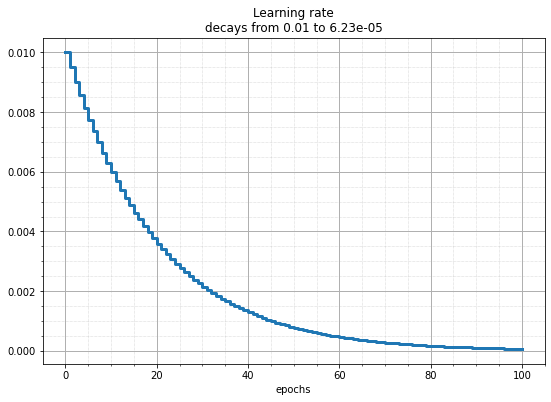

In [9]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.95, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.75):
      print("done!")
      self.model.stop_training = True

In [11]:
callbacks = myCallback()

history = model.fit(
      train_generator,
      steps_per_epoch=14,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=4,  # 1000 images = batch_size * steps
      verbose=2,
      callbacks = [lr_decay_callback, callbacks])


Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/100
14/14 - 7s - loss: 3.0502 - accuracy: 0.2857 - val_loss: 14.9302 - val_accuracy: 0.2250 - lr: 0.0100 - 7s/epoch - 502ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0095.
Epoch 2/100
14/14 - 3s - loss: 2.0038 - accuracy: 0.4071 - val_loss: 4.6014 - val_accuracy: 0.3000 - lr: 0.0095 - 3s/epoch - 246ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.009025.
Epoch 3/100
14/14 - 3s - loss: 1.9746 - accuracy: 0.3964 - val_loss: 11.5642 - val_accuracy: 0.2500 - lr: 0.0090 - 3s/epoch - 248ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.00857375.
Epoch 4/100
14/14 - 3s - loss: 1.9336 - accuracy: 0.4107 - val_loss: 5.3204 - val_accuracy: 0.2375 - lr: 0.0086 - 3s/epoch - 247ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.0081450625.
Epoch 5/100
14/14 - 3s - loss: 1.8363 - accuracy: 0.3929 - val_loss: 3.2081 - val_accuracy: 0.3500 

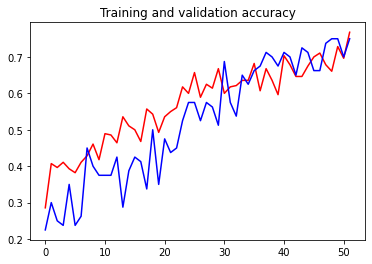

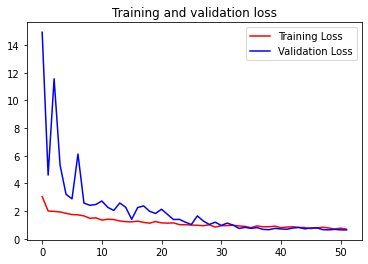

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy', color ='red')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss', color ='red')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Saving 89.jpg to 89.jpg
89.jpg
Predicted :-  kawung


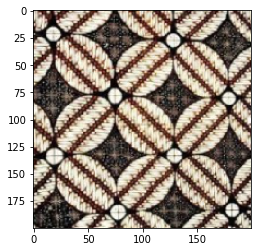

In [16]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(200,200))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  output = { 0:'kawung',1:'megamendung',2:'parang',3:'tambal'}

  print(fn)
  plt.imshow(img)
  print("Predicted :- ",output[np.argmax(classes)])
 

In [55]:
train_kawung_fnames = os.listdir( train_kawung_dir )
train_megamendung_fnames = os.listdir( train_megamendung_dir )
train_parang_fnames = os.listdir( train_parang_dir )
train_tambal_fnames = os.listdir( train_tambal_dir )

print(train_kawung_fnames[:10])
print(train_megamendung_fnames[:10])
print(train_parang_fnames[:10])
print(train_tambal_fnames[:10])

['60.jpg', '49.jpg', '46.jpg', '9.jpg', '48.jpg', '36.jpg', '16.jpg', '15.jpg', '61.jpg', '41.jpg']
['60.jpg', '49.jpg', '46.jpg', '9.jpg', '48.jpg', '36.jpg', '16.jpg', '15.jpg', '61.jpg', '41.jpg']
['60.jpg', '49.jpg', '46.jpg', '9.jpg', '48.jpg', '36.jpg', '16.jpg', '15.jpg', '61.jpg', '41.jpg']
['60.jpg', '49.jpg', '46.jpg', '9.jpg', '48.jpg', '36.jpg', '16.jpg', '15.jpg', '61.jpg', '41.jpg']


In [59]:
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(24, (3,3), input_shape=(150, 150, 3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(32, (6,6)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32, (6,6)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1)),

    tf.keras.layers.Conv2D(12, (3,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy'])

In [62]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model1.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model1.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
kawung_img_files = [os.path.join(train_kawung_dir, f) for f in train_kawung_fnames]
megamendung_img_files = [os.path.join(train_megamendung_dir, f) for f in train_megamendung_fnames]
parang_img_files = [os.path.join(train_parang_dir, f) for f in train_parang_fnames]
tambal_img_files = [os.path.join(train_tambal_dir, f) for f in train_tambal_fnames]

img_path = random.choice(kawung_img_files + megamendung_img_files + parang_img_files + tambal_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model1.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
